In [1]:
# Install kagglehub if not already installed
!pip install kagglehub --quiet

In [2]:
# --- Core imports
import os, json, joblib, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

# --- ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve, accuracy_score, f1_score
)

pd.set_option("display.max_columns", 100)

In [3]:
# Download to the default kagglehub cache
path = kagglehub.dataset_download("nikhil1e9/loan-default")
print("Dataset downloaded to:", path)

# Move/copy it to Downloads (You can move/copy the dataset wherever you want, but in this case, it is placed in the Downloads section for faster access.)
downloads_path = os.path.expanduser("~/Downloads/loan-default")
if not os.path.exists(downloads_path):
    shutil.copytree(path, downloads_path)

print("Copied to:", downloads_path)

# Load CSV (adjust filename to the actual one inside the folder)
df = pd.read_csv(f"{downloads_path}/Loan_Default.csv")  # check exact filename
df.head()

Dataset downloaded to: C:\Users\Ethaniel Agas\.cache\kagglehub\datasets\nikhil1e9\loan-default\versions\2
Copied to: C:\Users\Ethaniel Agas/Downloads/loan-default


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
print("Shape:", df.shape)
display(df.sample(5, random_state=42))
print("\nDtypes:")
display(df.dtypes)

print("\nMissing values:")
display(df.isna().sum().sort_values(ascending=False))

# Try to guess binary target columns (0/1 or two unique values)
candidates = []
for c in df.columns:
    unique_vals = df[c].dropna().unique()
    if df[c].nunique(dropna=True) == 2:
        candidates.append((c, unique_vals[:10]))
print("\nPotential binary target columns:", candidates)

Shape: (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
51139,CKV34LU7V7,55,112656,92393,581,113,2,23.54,36,0.15,PhD,Self-employed,Single,Yes,Yes,Home,No,0
71005,62KTYNH93J,56,91569,131575,641,54,1,15.19,12,0.43,High School,Part-time,Divorced,Yes,Yes,Education,Yes,0
35684,JGFUSOIUH7,26,78169,75417,569,105,3,18.02,12,0.29,Master's,Part-time,Married,Yes,Yes,Education,Yes,0
174087,4538THBHOX,26,63033,10804,326,118,1,14.71,24,0.41,High School,Part-time,Single,No,No,Business,Yes,0
137952,DXLNA06JHR,24,29665,21182,662,102,3,15.02,60,0.69,PhD,Unemployed,Single,No,Yes,Business,Yes,0



Dtypes:


LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object


Missing values:


LoanID            0
Age               0
HasCoSigner       0
LoanPurpose       0
HasDependents     0
HasMortgage       0
MaritalStatus     0
EmploymentType    0
Education         0
DTIRatio          0
LoanTerm          0
InterestRate      0
NumCreditLines    0
MonthsEmployed    0
CreditScore       0
LoanAmount        0
Income            0
Default           0
dtype: int64


Potential binary target columns: [('HasMortgage', array(['Yes', 'No'], dtype=object)), ('HasDependents', array(['Yes', 'No'], dtype=object)), ('HasCoSigner', array(['Yes', 'No'], dtype=object)), ('Default', array([0, 1], dtype=int64))]


In [5]:
TARGET = "Default"   # <-- CHANGE ME if needed (e.g., "Defaulted", "LoanStatus", etc.)
assert TARGET in df.columns, f"'{TARGET}' not found. Pick one from: {[c for c,_ in candidates]}"
y_raw = df[TARGET]
y_raw.value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

Numeric cols: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio'] ... (total: 9 )
Categorical cols: ['LoanID', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'] ... (total: 8 )


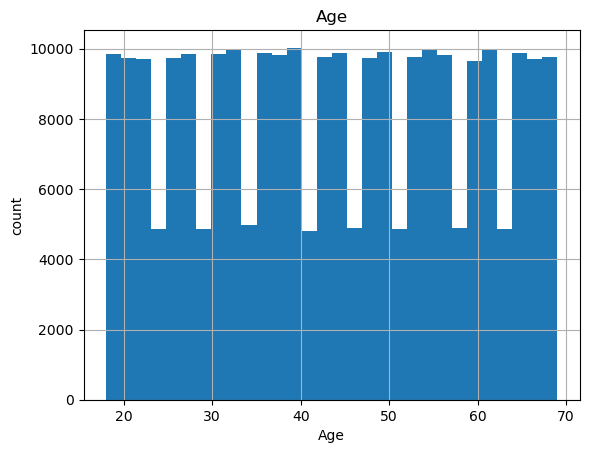

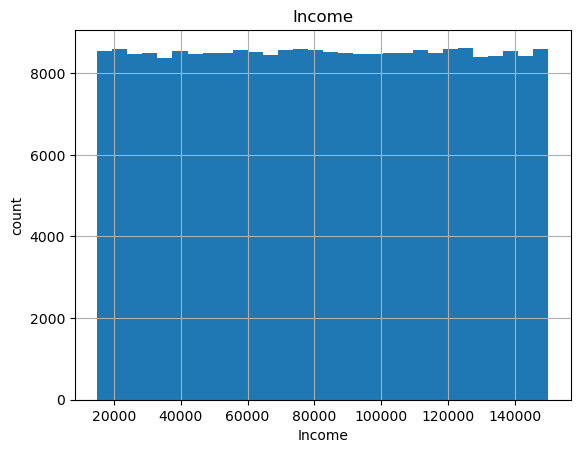

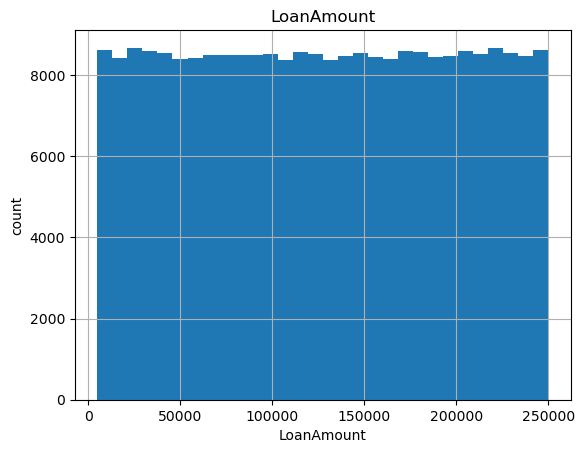

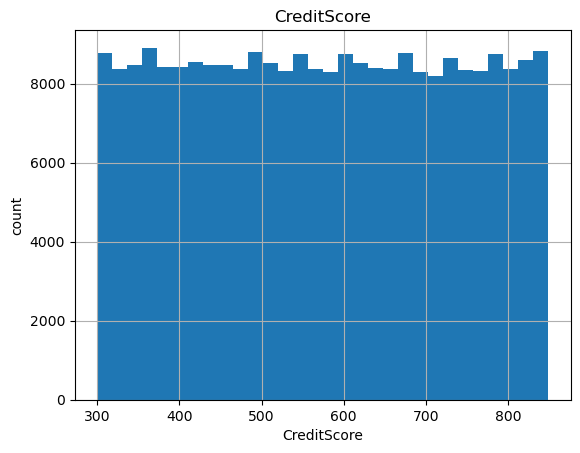

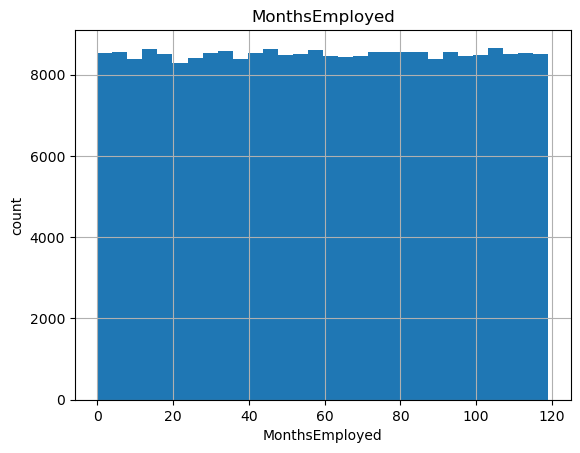

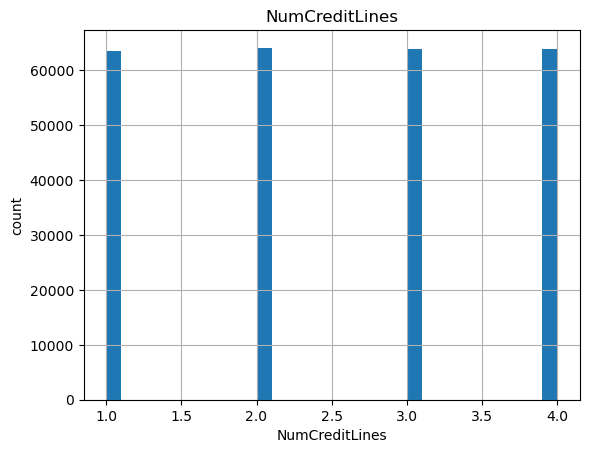

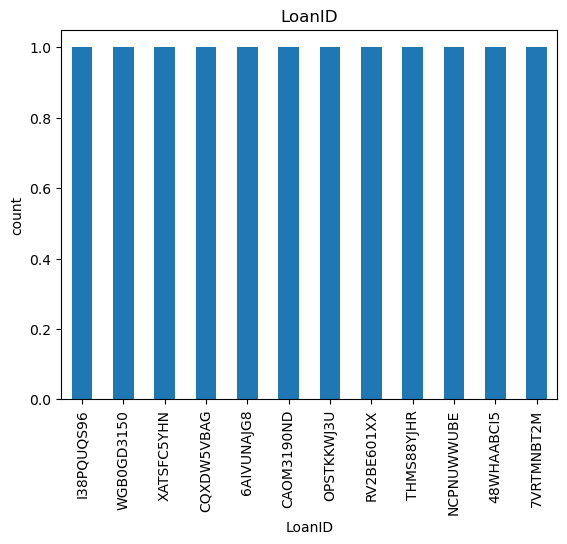

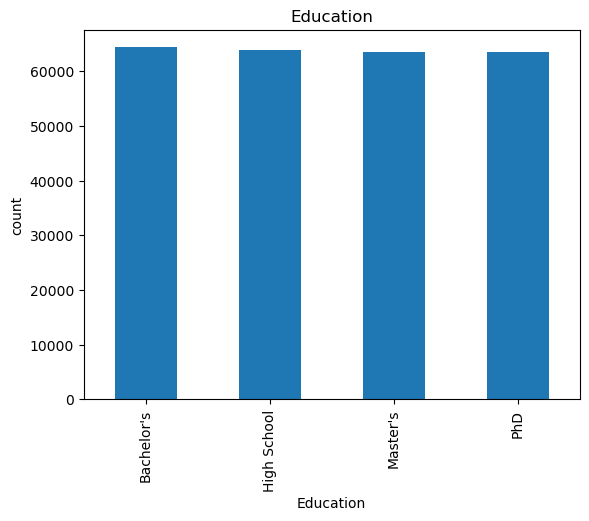

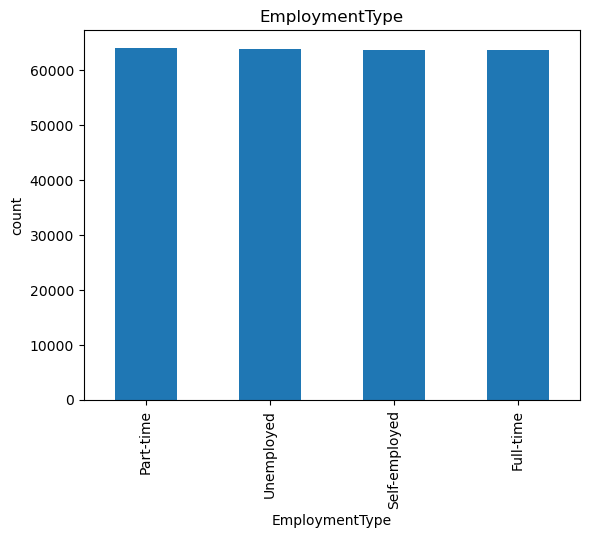

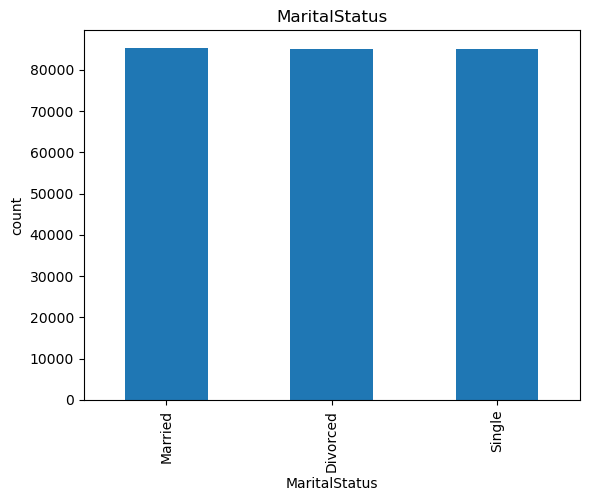

In [6]:
# Numeric / Categorical split (initial)
num_cols = df.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# Drop the target from these lists if present
num_cols = [c for c in num_cols if c != TARGET]
cat_cols = [c for c in cat_cols if c != TARGET]

print("Numeric cols:", num_cols[:12], "... (total:", len(num_cols), ")")
print("Categorical cols:", cat_cols[:12], "... (total:", len(cat_cols), ")")

# Histograms for a few numeric columns
for c in num_cols[:6]:
    df[c].hist(bins=30)
    plt.title(c)
    plt.xlabel(c); plt.ylabel("count")
    plt.show()

# Bar plots for a few categoricals (top categories)
for c in cat_cols[:4]:
    df[c].value_counts(dropna=False).head(12).plot(kind="bar")
    plt.title(c)
    plt.ylabel("count")
    plt.show()

In [7]:
# Make a working copy and drop obvious ID-like columns if they exist
X = df.drop(columns=[TARGET]).copy()

for col in ["LoanID","loan_id","ID","Id","CustomerID","customer_id"]:
    if col in X.columns:
        X.drop(columns=[col], inplace=True)

y = y_raw.astype(int) if y_raw.dropna().isin([0,1]).all() else y_raw

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Recompute dtypes after dropping any columns above
num_cols = X_train.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

len(num_cols), len(cat_cols)

(9, 7)

In [8]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# Choose one model to start (logistic baseline + gradient boosting)
models = {
    "logreg": LogisticRegression(max_iter=1000),
    "gboost": GradientBoostingClassifier(),
    # Optionally:
    "rf": RandomForestClassifier(n_estimators=300, random_state=42)
}

In [9]:
def fit_and_eval(model_name, model):
    pipe = Pipeline([("pre", pre), ("clf", model)])
    pipe.fit(X_train, y_train)

    metrics = {}
    for split_name, X_, y_ in [("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)]:
        # Some models have decision_function instead of predict_proba
        if hasattr(pipe, "predict_proba"):
            proba = pipe.predict_proba(X_)[:,1]
        else:
            # fall back for models without predict_proba
            scores = pipe.decision_function(X_)
            # map to 0-1 range via rank-based or min-max (rough). Prefer models with predict_proba.
            proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

        pred = (proba >= 0.5).astype(int)
        metrics[split_name] = dict(
            roc_auc = float(roc_auc_score(y_, proba)),
            pr_auc  = float(average_precision_score(y_, proba)),
            accuracy= float(accuracy_score(y_, pred)),
            f1      = float(f1_score(y_, pred))
        )

    return pipe, metrics

results = {}
fitted = {}

for name, mdl in models.items():
    pipe, m = fit_and_eval(name, mdl)
    fitted[name] = pipe
    results[name] = m

print(json.dumps(results, indent=2))

{
  "logreg": {
    "train": {
      "roc_auc": 0.74576618442287,
      "pr_auc": 0.3012521871729992,
      "accuracy": 0.8850354141723825,
      "f1": 0.06104637879826365
    },
    "val": {
      "roc_auc": 0.7486804185174339,
      "pr_auc": 0.3092746036977343,
      "accuracy": 0.8850451673541851,
      "f1": 0.06139415902792582
    },
    "test": {
      "roc_auc": 0.7573112400642181,
      "pr_auc": 0.316894178088882,
      "accuracy": 0.8853614599378639,
      "f1": 0.06514796678731105
    }
  },
  "gboost": {
    "train": {
      "roc_auc": 0.7599475377425258,
      "pr_auc": 0.3331816306819278,
      "accuracy": 0.8869320025511631,
      "f1": 0.09857270294380018
    },
    "val": {
      "roc_auc": 0.7555680207709534,
      "pr_auc": 0.3287317176834118,
      "accuracy": 0.8863505822150279,
      "f1": 0.09369144284821987
    },
    "test": {
      "roc_auc": 0.760273838970472,
      "pr_auc": 0.32794460025696565,
      "accuracy": 0.8857530741717359,
      "f1": 0.0909846281

Best model: gboost → {'roc_auc': 0.7555680207709534, 'pr_auc': 0.3287317176834118, 'accuracy': 0.8863505822150279, 'f1': 0.09369144284821987}

Classification report (test):
              precision    recall  f1-score   support

           0     0.8885    0.9957    0.9390     33855
           1     0.5984    0.0492    0.0910      4448

    accuracy                         0.8858     38303
   macro avg     0.7434    0.5224    0.5150     38303
weighted avg     0.8548    0.8858    0.8406     38303

Confusion matrix (test):
[[33708   147]
 [ 4229   219]]


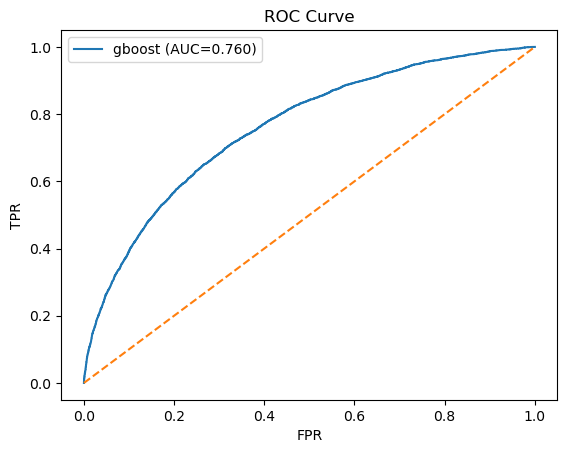

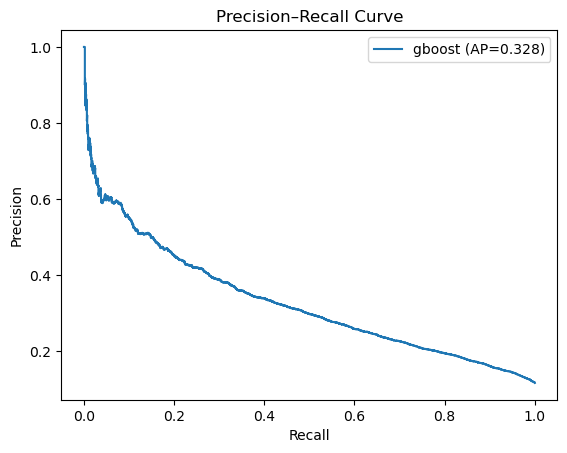

In [10]:
# Choose the model with highest validation ROC-AUC
best_name = max(results, key=lambda k: results[k]["val"]["roc_auc"])
best_pipe = fitted[best_name]
print("Best model:", best_name, "→", results[best_name]["val"])

# Classification report & confusion matrix on TEST
if hasattr(best_pipe, "predict_proba"):
    test_proba = best_pipe.predict_proba(X_test)[:,1]
else:
    s = best_pipe.decision_function(X_test)
    test_proba = (s - s.min())/(s.max()-s.min()+1e-9)

test_pred = (test_proba >= 0.5).astype(int)

print("\nClassification report (test):")
print(classification_report(y_test, test_pred, digits=4))

print("Confusion matrix (test):")
print(confusion_matrix(y_test, test_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc_score(y_test, test_proba):.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()

# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_test, test_proba)
ap = average_precision_score(y_test, test_proba)
plt.plot(rec, prec, label=f"{best_name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve"); plt.legend()
plt.show()

In [11]:
artifact = {
    "pipeline": best_pipe,
    "numeric": num_cols,
    "categorical": cat_cols,
    "target": TARGET,
    "metrics": results
}
joblib.dump(artifact, "model.pkl")
print("Saved model.pkl")

Saved model.pkl


In [12]:
# Build a single sample from median/mode of training set
row = {}
for c in num_cols:
    row[c] = float(np.nanmedian(X_train[c])) if X_train[c].dtype != "bool" else bool(X_train[c].mode(dropna=True)[0])
for c in cat_cols:
    row[c] = X_train[c].mode(dropna=True)[0] if X_train[c].notna().any() else None

# Predict
loaded = joblib.load("model.pkl")["pipeline"]
proba = float(loaded.predict_proba(pd.DataFrame([row]))[:,1][0])
pred  = int(proba >= 0.5)
print("Sanity prediction → prob_default:", round(proba, 4), "| pred_default:", pred)
row

Sanity prediction → prob_default: 0.0711 | pred_default: 0


{'Age': 43.0,
 'Income': 82530.0,
 'LoanAmount': 127455.0,
 'CreditScore': 574.0,
 'MonthsEmployed': 60.0,
 'NumCreditLines': 3.0,
 'InterestRate': 13.43,
 'LoanTerm': 36.0,
 'DTIRatio': 0.5,
 'Education': "Bachelor's",
 'EmploymentType': 'Part-time',
 'MaritalStatus': 'Married',
 'HasMortgage': 'Yes',
 'HasDependents': 'Yes',
 'LoanPurpose': 'Business',
 'HasCoSigner': 'Yes'}